# Multi-Disciplinary Design Optimization
## Abstract
This is a program for generating an optimized rocket based on a feasible initial design and some fixed parameters. It depends on two subprograms, *trajectory* (which models a rocket based on the design variables, and simulates its trajectory) and *openrocket_interface* (which models an engine based on the design variables and simulation, and generates an OpenRocket model and corresponding engine for further testing). This program uses the Nelder-Mead simplex method to minimize mass while satisfying a number of mission constraints

## User Requirements
* Patience
* 'optimization' directory from Cory's branch of the liquid-engine-analysis repo
* OpenRocket
    * This depends on Java 8
    * Technically, mostly everything will work fine without OR, but it will get confused at the very end if it tries to put the engine file in a directory that doesn't exist. If you manually create the folder, it will be fine.
* Python3
* Jupyter Notebook
* Scipy
* Numpy
* Matplotlib

## Standard Operating Procedure
1. Review assumptions of *openrocket_interface* and make appropriate modifications (if any) to parameters at the beginning of that code. Save if you do.
2. Review assumptions of *trajectory* and make appropriate modifications (if any) to parameters at the beginning of that code. Save if you do.
3. Review assumptions of *optimizer* and make appropriate modifications (if any) to parameters at the beginning of this code.
4. Set initial design variables.
    * Note, garbage in, garbage out applies. If you start with a design that ends outside of the altitude window, you will waste 20 minutes of your life.
    * I would recommend running *trajectory* with your design first to make sure its final altitude is within the constraints. That is the only necessary condition.
5. Run all the code blocks in this notebook in sequential order!
6. Go run errands, and there will be a nice surprise waiting for you when you get back.

## Motivation
Rocket science is incredibly difficult and PSAS is holding my family hostage in the basement of the Engineering building (just kidding, rocket science is easy!).

There is an infinite number of possible rockets, but only a (still infinite) subset of those are both buildable by PSAS and feasible for achieving the Base-11 mission. However, only a finite sequence of designs of those rockets will be seen by human eyes, the last of which will (hopefully) correspond closely with the one and only rocket that is actually built and which (hopefully) successfully completes its mission.

Enter math.

## Method
We may construct an objective function that represents the quality of our rocket. We use Gross Liftoff Weight (GLOW) to determine this, since dry mass is our greatest enemy and propellant mass is our most fickle frenemy.

We may use a series of penalty and barrier functions to represent the constraints of our mission. These will be detailed in the next section.

Together, this gives us a merit function to minimize. Because our problem is (mathematically speaking) terrible as a result of a simulation standing between design vectors and the variables of our merit function, we use the Nelder-Mead method, a directed search that doesn't use derivatives. Theoretically, there are other methods possible, such as estimating derivatives by finite differences for gradient-based methods, or constructing and optimizing on a response surface model that is itself only a calculus-and-statistics-friendly model of our simulation model. We could also do a genetic algorithm or Monte-Carlo simulation, or some other stochastic optimization method, or even some sort of Latin Square trade-analysis. However, I hate all these options because I don't understand them yet and the previous MDO used the Nelder-Mead method too.

Where we deviate significantly from the previous MDO is in our decision to do an iterative sequence of optimization problems instead of just one. There was a good reason for this that I can't remember how to articulate properly, so I will come back and explain later. Also, the previous optimizer just returned the least garbage rocket it found based on unsatisfiable constraints (TWR > 8, the main culprit), while now we demand a strictly feasible rocket.

We technically may not speak of "convergence", since it is possible for the Nelder-Mead method to stagnate on non-stationary points as the geometry of a simplex becomes ill-conditioned. However, since we are doing a sequence of optimizations, I'm not too concerned since the geometry is reset for each one. I suspect that we converge to at least the neighborhood of a local minimum, but not having seen a heatmap of the design space, I hesitate to say anything besides that we find feasible rockets. 

## Assumptions
* If an optimization iteration returns a vector within $10^{-6}$ of the last iteration, there is no point in going further.
* A simulation time-step of 0.25 s is good enough but not too good.
* 25 iterations is a reasonable maximum number to perform.
* The launch site has an altitude of 1401 m (this is true).
* Our initial design vector is already feasible (garbage in, garbage out).
* A 12" diameter is a reasonable stipulation.
    * If this is wider, then drag becomes horrible, if this is thinner, then the L/D ratio becomes unreasonable. The standing assumption was already that LV4 would be 12", so I made this a fixed parameter instead of a design variable. Hopefully this protects us from the curse of dimensionality, at least a little.
    * Our optimization algorithm also performs poorly in high-dimensional spaces, so this is somewhat of a reasonable assumption. It would be trivial to make it a design variable again, but we are moving forward as is.
* Our constraints are reasonable. 
    * I changed the max L/D ratio from 15 to 18 and reduced the min T/W ratio from 8 to 2 because otherwise there are no feasible designs.
    * I added a constraint for launch speed as a stand in for aerodynamic stability and I added a constraint for thrust since we are now stipulating the thrust of the rocket.
    * I increased the minimum altitude to account for launch site altitude and to give us room for inefficiency, and added a maximum altitude to conform to Base-11 requirements (as well as to ensure our merit function remains above 0).
* Our merit function is numerically well-conditioned.
* A sequence of optimization problems is better than a single optimization.
* The Nelder-Mead method (specifically SciPy's implementation) is ideal to be using.

# Parameters and Utility Functions
Copied and slightly modified from the previous MDO,

"We expect overall project costs to scale with the initial mass of the launch vehicle (including the mass of loaded propellants), which is usually defined by the Gross Lift-Off Weight (GLOW). Therefore the objective of the optimization is to minimize GLOW.  

For a top-level early concept development we can distill the key design variables to just propellant tank lengths, mass flow rate, and exit pressure and determine all other relevant variables from those and our design constants. There are a large number of design constants present in the models, which include specific impulse, combustion chamber pressure, propellant mixture ratio, and others, but which for the sake of brevity will be largely ignored in the following discussion. The model currently includes 7 inequality constraints:

* Apogee $h$: The minimum and maximum altitude on the trajectory
* Thrust $F$: This is a design constant, but we treat it as a variable since it changes as a function of our variables
* Launch Speed $LS$: When the rocket leaves the launch rail we don't want it to tip over
* Thrust-to-Weight Ratio $TWR$: Trade-off between gravity loss and aerodynamic stability
* Length to Diameter Ratio $L/D$: Trade-off between aerodynamic stability and mechanical (non-rigid body) resonance modes
* Maximum acceleration $\frac{a_{max}}{g_0}$: Set by the material limits of various launch vehicle subsystems
* Nozzle over-expansion $\frac{p_e}{p_a}$: Prevents the assumption made to help linearize thrust model from becoming invalid

Mathematically the problem can be roughly stated as

$$f_{n}(\bar{x}) = m(\bar{x}) + \mu_{n}\sum h(\bar{x}) + \rho_{n}\sum g(\bar{x})$$
$$ \lim_{n \to \infty} \mu_{n} = 0$$
$$ \lim_{n \to \infty} \rho_{n} = \infty$$
$$ \lim_{n \to \infty} \min_{\bar{x}} f_{n}(\bar{x}) = \bar{x}^{*}$$


\begin{eqnarray*} \mbox{where} \hspace{5 mm}
    \begin{split}\bar{x} = \left\{
        \begin{array}{ll}      & \dot{m}\\
          & L\\
          & p_e \end{array}
        \right. \end{split}
    \hspace{2 mm} \mbox{, subject to} \hspace{2 mm}
    \begin{split}
        h_{barrier} = \left\{
        \begin{array}
            & 108401 < h < 151401 \hspace{1 mm} m
            \end{array}
        \right. \end{split}
    \hspace{2 mm} \mbox{, and subject to} \hspace{2 mm}
    \begin{split}
          g_{penalty} = \left\{
          \begin{array}{ll}
              & F = 6 \hspace{1 mm} kN\\
              & LS \geq 22 \hspace{1 mm} m/s\\
              & \frac{a_{max}}{g_0} \leq 15 \hspace{1 mm} g's\\
              & TWR \geq 2\\
              & L/D \leq 18\\
              & \frac{p_e}{p_a} \geq 0.35\\
              \end{array}
          \right. \end{split}
    \end{eqnarray*}

While the objective function itself is given by a very simple function of the design variables $D$ and $L$, the constraints require a much more complex model. The following section discusses the trajectory simulation model required to capture values of these constraints for any particular design vector."

I will clean the above section very soon after a brief literature review for proper nomenclature.

In [91]:
# Nelder-Mead simplex search
%matplotlib inline
import numpy as np
from math import sqrt, pi, exp, log, cos
from scipy.optimize import minimize, differential_evolution
import pylab
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
%run openrocket_interface.ipynb
%run trajectory.ipynb

# i'm sorry for global vars...
global allvectors, dbz, allobjval
dbz = 0 # arithmetic error tracker (from crossing boundary constraints)

# SIMULATION AND OPTIMIZATION PARAMETERS
delta = 10**(-6)       # a guess at a good margin for design "convergence"
mu_0 = 0.005 # barrier parameter, this value lets altitudes approach lower bound pretty quickly
rho_0 = 2.5  # penalty parameter, i'm still playing with this value.
time_step = 0.25       # change time-step for trajectory simulation
iterations = 25        # number of escalating iteration sequences
launch_site_alt = 1401 # m, altitude of launch site above sea level

##CHANGE INITIAL DESIGN GUESS HERE
# be sure that you start with a feasible design, otherwise the problem will be ill-conditioned
L = 1.4    # Total tank lengths (m)
mdot = 2.1 # Propellant mass flow rate (kg/s)
dia = 12.  # Rocket diameter (in)
p_e = 47.  # Exit Pressure (kPa)

#CHANGE CONSTRAINTS HERE
cons_mass = 200.                         # GLOW constraint, kg, somewhat arbitrary
cons_ls = 22.                            # min launch speed from 60' tower constraint, m/s
cons_TWR = 2.                            # TWR constraint
cons_S_crit = 0.35                       # Critical pressure ratio constraint
cons_accel = 15.                         # Max acceleration constraint, g's
cons_LD = 18.                            # L/D ratio constraint, slightly arbitrary
cons_alt = 107000. + launch_site_alt     # Min altitude constraint, km (adjusted to overshoot)
cons_thrust = 6.                         # max ground-level thrust, kN
cons_ceiling = 150000. + launch_site_alt # base-11 maximum apogee requirement, km

X0 = np.array([L, mdot, p_e]) # numpy arrays are nicer
#X0 = np.array([L, mdot, p_e, dia]) # in case we want diameter to be a design variable
allvectors = []               # array for all design vecs, global variable
allobjfun = []                # array for tracking objective function evaluations

# calculates length-diameter ratio
def ld_ratio(sim):
    return sim.total_length / sim.dia
    
# calculates top g-force
def max_g_force(a):
    return max(abs(a)) / g_n

# Math Utility Functions
I chose to abstract all of the functions used within the merit function for increased flexibility and ease of reading later on.

* *objective* is arbitrarily constructed.
    * It is normalized (by a somewhat arbitrary constant) to bring it to the same range as constraints,
    * squared to reward (or punish) proportionally to the distance from whatever value we consider nominal (the arbitary constant), and
    * divided by two so that our nominal value is 0.5 instead of 1.0.
* *exact* is arbitrarily constructed.
    * We could use an absolute value function instead of squaring, the point is that it is horizontally symmetric.
    * Punishment is proportional to the distance from equality
    * Division by two is to bring the scale to where I like it (and for aesthetic value).
* *exterior* is not particularly arbitrary. It is boolean so that we can specify whether it is minimizing or maximizing its variable.
    * When the inequality is satisfied, it returns 0, otherwise it is just as punishing as *exact*.
* *barrier* comes in two flavors, one of which I hate. I like logarithms and you should too. It can also point in either direction.
    * Technically this allows for negative penalties (i.e. rewards), but since we use upper and lower altitude  barriers, it is literally impossible that their sum be less than 0.
    * The previous MDO didn't use a barrier function, but exterior penalties can be violated and any rocket that violates our altitude constraints is utter and complete garbage. Hence, this.

In [92]:
# all of our comparisons are ratios instead of subtractions because
# it's normalized, instead of dependant on magnitudes of constraints

# minimize this, **2 makes it well behaved w.r.t. when var=cons
def objective(var, cons):
    return (var/cons)**2 / 2

# **2 because i like it more than abs(), but that also works
def exact(var, cons):
    return (var/cons - 1)**2 / 2

# this is your basic exterior penalty, either punishes for unfeasibility or is inactive
def exterior(var, cons, good_if_less_than=False):
    if good_if_less_than:
        return max(0, var/cons - 1)**2 / 2
    else:
        return max(0, -(var/cons - 1))**2 / 2

# this barrier function restricts our objective function to the strictly feasible region
# make rockets great again, build that wall, etc, watch out for undefined operations
def barrier(var, cons, int_point=False, good_if_less_than=True):
    global dbz
    try: # just in case we accidentally leave feasible region
        if not int_point:
            if good_if_less_than:
                return -log(-(var/cons - 1))
            else:
                return -log(var/cons - 1)
        elif int_point:
            def interior(g): return 1/g # in case we don't like logarithms, which is a mistake
            if good_if_less_than:
                return -interior(var/cons - 1)
            else:
                return -interior(-(var/cons - 1))
    except:
        dbz += 1 # keep track of arithmetic errors, side effect
        return float('inf') # ordinarily, this is bad practice since it could confuse the optimizer
                            # however, since this is a barrier function not an ordinary penalty, i think it's fine

# Optimization Problem
See how nicely our penalty function is phrased? We simply give it arguments, then it uses the constants defined above to create arrays of all the penalties according to what type they are, which can be summed and multiplied by arbitrary constants to our hearts desire. Read and weep.

One thing to note is that $\mu$ and $\rho$ are different penalty parameters with very different limits. There are some good reasons for this, but I need to review my notes before I can tell you exactly why this is nice. Basically, each iteration is allowed to get closer to the barrier but punished more for leaving the feasible region.

One may note that $\{\mu_n\}$ and $\{\rho_n\}$ are essentially arbitrary sequences that I have constructed for a combination of niceness (initial values) and simplicity (halving and doubling).

Given a design vector $x$ and the iteration number $n$ our pseudo-objective function $f$ runs a simulation to grab some variables for evaluating the quality of that rocket. We keep track of each rocket and its merit evaluation for later visualization, hence why global variables are used. This function is what will be given to each iteration of the optimizer method, along with an initial design and the iteration number.

We run an iterative sequence of optimizations for the win. We use Euclidean distance to decide when it is no longer worth optimizing. Personally, I enjoy arbitrary precision, but reality seems to only care about the first 4 to 6 decimal places. I'm not certain its safe to terminate early by this criterion, but you could always remove that ability and add iterations if you have an extraordinary reserve of patience.

In [93]:
# this manages all our constraints
# penalty parameters: mu -> 0 and rho -> infinity 
def penalty(ls, F, LD, TWR, S_crit, alt, max_g, mu, rho):
    b = [barrier(alt, cons_alt, int_point=False, good_if_less_than=False),
         barrier(alt, cons_ceiling, int_point=False, good_if_less_than=True)]
    eq = [exact(F, cons_thrust)]
    ext = [exterior(ls, cons_ls, good_if_less_than=False),
           exterior(LD, cons_LD, good_if_less_than=True),
           exterior(TWR, cons_TWR, good_if_less_than=False),
           exterior(S_crit, cons_S_crit, good_if_less_than=False),
           exterior(max_g, cons_accel, good_if_less_than=True)]
    return mu*sum(b) + rho*(sum(eq) + sum(ext))

# Pseudo-objective function
# x is array of design parameters, n is sequence index of penalty and barrier functions
# print blocks are sanity checks so i'm not staring at a blank screen and can see what various tweaks actually do
def f(x, n=8):
    global allvectors, allobjfun
    L    = x[0]  # Tank length (m)
    mdot = x[1]  # Propellant mass flow rate (kg/s)
    p_e  = x[2]  # Pressure (kPa)
    #dia = x[3] # in case we want diameter to be a design variable
    
    # get trajectory data from x
    sim = trajectory(L, mdot, dia, p_e, x_init=launch_site_alt, dt=time_step)
    
    obj_func = objective(sim.m[0], cons_mass) # minimize GLOW
    # then, calculate penalization from trajectory based on initial thrust
    pen_func = penalty(sim.launch_speed,
                  sim.F[0]/1000,
                  ld_ratio(sim),
                  sim.TWR,
                  sim.S_crit,
                  sim.alt[-1],
                  max_g_force(sim.a),
                  mu_0 / (2**n),   # initial mu and
                  rho_0 * (2**n)) #                 rho are selected for nice behavior
    # add objective and penalty functions
    merit_func = obj_func + pen_func
    
    allvectors.append(x) # maintains a list of every design, side effect
    allobjfun.append(log(merit_func)) # log plot is cleaner to look at, for later
    return merit_func

# we want to iterate our optimizer for theoretical "convergence" reasons (given some assumptions)
# n = number of sequential iterations
def iterate(f, x_0, n):
    x = x_0 # initial design vector
    global dbz
    designs = []
    for i in range(n):
        print("Iteration " + str(i+1) + ":")
        # this minimizer uses simplex method
        res = minimize(f, x, args=(i), method='nelder-mead', options={'disp': True, 'adaptive':True})
        x = res.x # feed optimal design vec into next iteration
        #dia = x[3] # in case we want diameter to be a design variable
        
        designs.append(res.x)   # we want to compare sequential objectives 
                                # so we can stop when convergence criteria met
        alt = trajectory(x[0], x[1], dia, x[2], x_init=launch_site_alt, dt=time_step).alt
        
        print("         Arithmetic errors (from violations of acceptable altitude window): "+str(dbz))
        print("Preadjusted propellant tube length (m): "+str(x[0]))
        print("Mass flow rate (kg/s): "+str(x[1]))
        print("Exit pressure (kPa): "+str(x[2]))
        print("Peak Altitude (km): "+str(alt[-1]/1000))
        print('')
        dbz=0 # I only care about divisions by zero in each individual iteration, side effect
        if (i > 0) and (sqrt(sum([(designs[-1][k] - designs[-2][k])**2 for k in range(len(x))])) < delta):
            print("Early termination! The Euclidean distance between the last two designs was < " + str(delta))
            break
    return x

# Optimization Information and Graphing
All this junk is just for the benefit of our intuition so we can visualize the design space and our final trajectory. Nothing exciting or special happens in this code. I can comment it, I guess.

In [94]:
# this creates a list of strings for relevant data of trajectory
def print_results(res):
    text_base = [] # list of lines of strings
    
    # Rename the optimized output for convenience
    L    = res[0]
    mdot = res[1]
    p_e  = res[2]
    #dia = res[3] # in case we want diameter to be a design variable
    
    sim = trajectory(L, mdot, dia, p_e, x_init=launch_site_alt, dt=time_step) 
    
    np.set_printoptions(precision=3) # this line may be deprecated, i copy-pasted most of this section
    
    text_base.append('\nOPTIMIZED DESIGN VECTOR')
    text_base.append('\n-----------------------------')
    text_base.append('\nx_initial_guess                            = ' + ', '.join(
                                                                            [str(X0[0]), str(X0[1]), str(X0[2])]))
    text_base.append('\ninitial guess GLOW                                    = {:.1f} kg'.format( \
          trajectory(X0[0], X0[1], dia, X0[2], x_init=launch_site_alt, dt=time_step).m[0]))
    text_base.append('\nx_optimized                                = ' + ', '.join([str(L), str(mdot), str(p_e)]))
    text_base.append('\ndesign tankage length (before adjustment)  = {:.3f} m'.format(L))
    text_base.append('\ndesign mass flow rate                      = {:.3f} kg/s'.format(mdot))
    text_base.append('\ndesign nozzle exit pressure                = {:.3f} kPa'.format(p_e))
    text_base.append('\ndesign tankage length (after adjustment)   = {:.3f} m'.format(sim.l_o + sim.l_f))
    text_base.append('\ndesign airframe diameter                   = {:.3f} in.'.format(dia))
    text_base.append('\ndesign airframe total length               = {:.3f} m.'.format(sim.total_length))
    text_base.append('\ndesign GLOW                                = {:.3f} kg'.format(sim.m[0]))
    
    text_base.append('\n')
    text_base.append('\nCONSTRAINTS')
    text_base.append('\n-----------------------------')
    text_base.append('\nL/D ratio (c.f. < {})                      = {:.3f}'.format(
                                                                            cons_LD, ld_ratio(sim)))
    text_base.append('\nSommerfield criterion (c.f. pe/pa >= {})   = {:.3f}'.format(cons_S_crit, sim.S_crit))
    text_base.append("\nmax acceleration (c.f. < {})               = {:.3f} gs".format(
                                                                                cons_accel, max_g_force(sim.a)))
    text_base.append('\nTWR at lift off (c.f. > {})                 = {:.3f}'.format(cons_TWR, sim.TWR))
    text_base.append('\nspeed when leaving launch rail (c.f. > {}) = {:.3f} m/s'.format(cons_ls,sim.launch_speed))
    text_base.append('\naltitude at apogee (c.f. > {})          = {:.3f} km'.format(
                                                                                cons_alt/1000, sim.alt[-1]/1000))
    text_base.append('\ndesign thrust (ground level) (c.f. = {})    = {:.3f} kN'.format(
                                                                                     cons_thrust, sim.F[0]/1000))

    text_base.append('\n')
    text_base.append('\nADDITIONAL INFORMATION')
    text_base.append('\n-----------------------------')
    text_base.append('\ndesign thrust (vacuum)                     = {:.2f} kN'.format(sim.F[sim.F_index]/1000))
    text_base.append('\ndesign total dry mass                      = {:.3f} kg'.format(sim.m_dry))
    text_base.append('\ndesign total propellant mass               = {:.3f} kg'.format(sim.m_prop[0]))
    text_base.append('\naltitude at engine ignition                = {:.1f} m'.format(launch_site_alt))
    text_base.append('\nmission time at apogee                     = {:.3f} s'.format(sim.t[-1]))
    text_base.append('\nmission time at burnout                    = {:.3f} s'.format(sim.t[sim.F_index]))
    text_base.append('\ndesign chamber pressure                    = {:.3f} psi'.format(350))
    text_base.append('\ndesign expansion ratio                     = {:.3f}'.format(sim.ex))
    text_base.append('\ndesign throat area                         = {:.3f} in.^2'.format(sim.A_t/0.0254**2))
    text_base.append('\ndesign isp                                 = {:.3f} s'.format(sim.Ve/g_n))
    text_base.append('\ndesign total impulse                       = {:.3f} kN*s'.format(
                                                  sim.t[sim.F_index]*(sim.F[sim.F_index]/1000 + sim.F[0]/1000)/2))
    text_base.append('\ndesign dV                                  = {:.3f} km/s'.format(sim.dV1))
    text_base.append('\nestimated minimum required dV              = {:.3f} km/s'.format(
                                                                                    sqrt(2*g_n*sim.alt[-1])/1000))
    return text_base

# this creates a nice set of plots of our trajectory data and saves it to rocket_farm
def rocket_plot(t, alt, v, a, F, q, Ma, m, p_a, D):
    pylab.rcParams['figure.figsize'] = (10.0, 10.0)
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, sharex=True)
    
    for n in (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9):
        n.spines['top'].set_visible(False)
        n.spines['right'].set_visible(False)
        n.yaxis.set_ticks_position('left')
        n.xaxis.set_ticks_position('bottom')
        n.yaxis.labelpad = 20
        
    ax1.plot(t, alt/1000, 'k')
    ax1.set_ylabel("Altitude (km)")
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_title('LV4 Trajectory')
    
    ax2.plot(t, v, 'k')
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_ylabel("Velocity (m/s)")
    
    ax3.plot(t, a/g_n, 'k')
    ax3.yaxis.major.locator.set_params(nbins=10)
    ax3.set_ylabel("Acceleration/g_n")
    
    ax4.plot(t, F/1000, 'k')
    ax4.yaxis.major.locator.set_params(nbins=6)
    ax4.set_ylabel("Thrust (kN)")
    
    ax5.plot(t, q/1000, 'k')
    ax5.yaxis.major.locator.set_params(nbins=6)
    ax5.set_ylabel("Dynamic Pressure (kPa)")
    
    ax6.plot(t, Ma, 'k')
    ax6.yaxis.major.locator.set_params(nbins=6) 
    ax6.set_ylabel("Mach number")
    ax6.set_xlabel("t (s)")
    
    ax7.plot(t, np.array(m)*0.666*np.array(a), 'k')
    ax7.yaxis.major.locator.set_params(nbins=6) 
    ax7.set_ylabel("LOX Tank Axial Load")
    ax7.set_xlabel("t (s)")
    
    ax8.plot(t, D, 'k')
    ax8.yaxis.major.locator.set_params(nbins=6)
    ax8.set_ylabel("Drag (N)")
    
    ax9.plot(t, p_a/1000, 'k')
    ax9.yaxis.major.locator.set_params(nbins=6)
    ax9.set_ylabel("Air Pressure (Pa)")
    
    # we save the nice figures we make and then display them
    plt.savefig(rkt_prefix +'psas_rocket_'+str(get_index()-1)+'_traj.svg')
    plt.show()

# this creates some plots of the phase spaces of all our designs, doesn't save them
def phase_plot(L, mdot, p_e):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    
    ax1.plot(L, p_e)
    ax1.set_title('Design Vectors')
    ax1.yaxis.major.locator.set_params(nbins=6)
    ax1.set_xlabel("Length (m)")
    ax1.set_ylabel("Exit pressure (kPa)")
    
    ax2.plot(mdot, p_e)
    ax2.yaxis.major.locator.set_params(nbins=6)
    ax2.set_xlabel("Mass flow rate (kg/s)")
    ax2.set_ylabel("Exit pressure (kPa)")
    
    ax3.plot(L, mdot)
    ax3.yaxis.major.locator.set_params(nbins=6)
    ax3.set_ylabel("Mass flow rate (kg/s)")
    ax3.set_xlabel("Length (in)")
    
    # we display the first diagram of projected 2d phase portraits
    plt.show()
    
    fig2 = plt.figure()
    ax = fig2.add_subplot(111, projection='3d')
    ax.set_title('Design Space Trajectory')
    ax.plot(L, mdot, p_e)
    ax.set_xlabel("Length (m)")
    ax.set_ylabel("Mass flow rate (kg/s)")
    ax.set_zlabel("Exit pressure (kPa)")
    
    # we display the interactive 3d phase portrait
    plt.show()
    # note, we're choosing to not automatically save these, but they can be saved from the interface
    fig3 = plt.figure()
    ax = fig3.add_subplot(111)
    ax.set_title('Design Values as % of optimum design value')
    ax.plot(L/(L[-1]), "r", label="L")
    ax.plot(mdot/(mdot[-1]), "g", label="Mdot")
    ax.plot(p_e/(p_e[-1]), "b", label="p_e")
    ax.legend()
    plt.show()

def design_grapher(): # no arguments because I'm using dirty dirty global variables
    # get us some nice plots of the phase space of design vectors
    designplot = [[],[],[]]
    for i in range(0, len(allvectors)):
        for j in range(0, len(designplot)):
            designplot[j].append(allvectors[i][j])
    phase_plot(designplot[0], designplot[1], designplot[2])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Objective + Constraint convergence')
    ax.plot(allobjfun, "r", label="Objective Function Evaluations (Logarithmic Scale)")
    ax.legend()
    plt.show()

# Top-Level of Optimization Routine
Here's where the magic happens. It runs the iterative optimization, looks at that trajectory, and uses the OpenRocket interface to spit out a nice little rocket and engine for us to play with, and then shoots out a bunch of visuals.

Iteration 1:


/usr/lib/python3/dist-packages/ipykernel_launcher.py:54: OptimizeWarning: Unknown solver options: adaptive


Optimization terminated successfully.
         Current function value: 0.380706
         Iterations: 127
         Function evaluations: 250
         Arithmetic errors (from violations of acceptable altitude window): 45
Preadjusted propellant tube length (m): 1.30484851704
Mass flow rate (kg/s): 2.43917998155
Exit pressure (kPa): 48.2732183935
Peak Altitude (km): 111.13367888

Iteration 2:
Optimization terminated successfully.
         Current function value: 0.367741
         Iterations: 93
         Function evaluations: 185
         Arithmetic errors (from violations of acceptable altitude window): 76
Preadjusted propellant tube length (m): 1.29842838911
Mass flow rate (kg/s): 2.44293960451
Exit pressure (kPa): 49.5355557916
Peak Altitude (km): 109.754468803

Iteration 3:
Optimization terminated successfully.
         Current function value: 0.360564
         Iterations: 140
         Function evaluations: 272
         Arithmetic errors (from violations of acceptable altitude window): 

New rocket generated from template!
Reopen OpenRocket to run simulation.


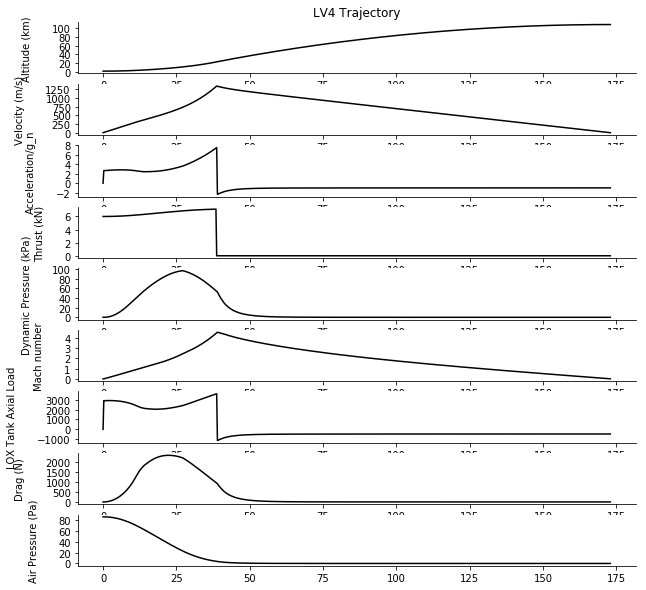

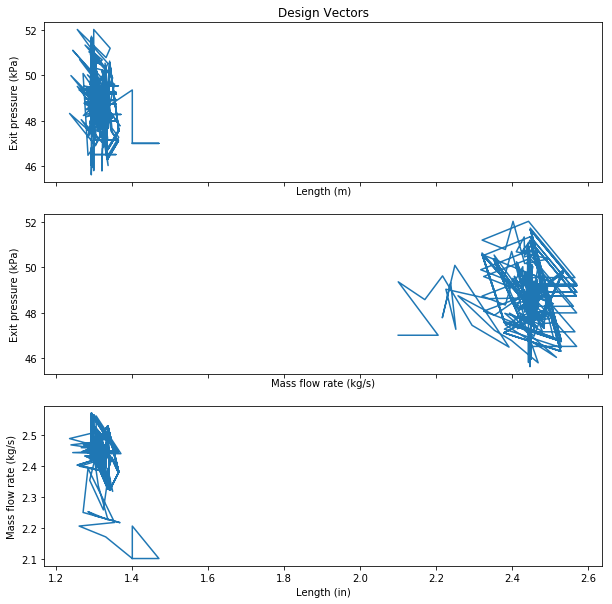

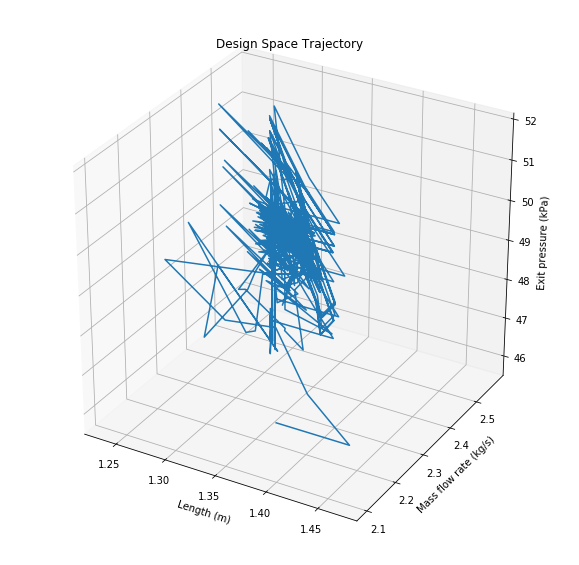

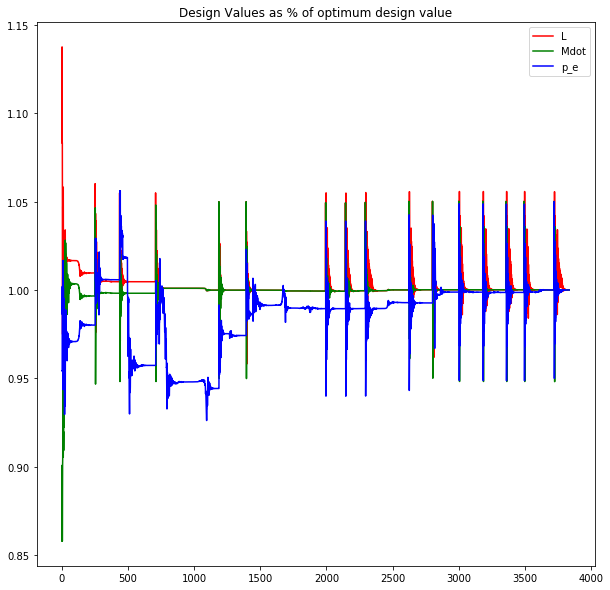

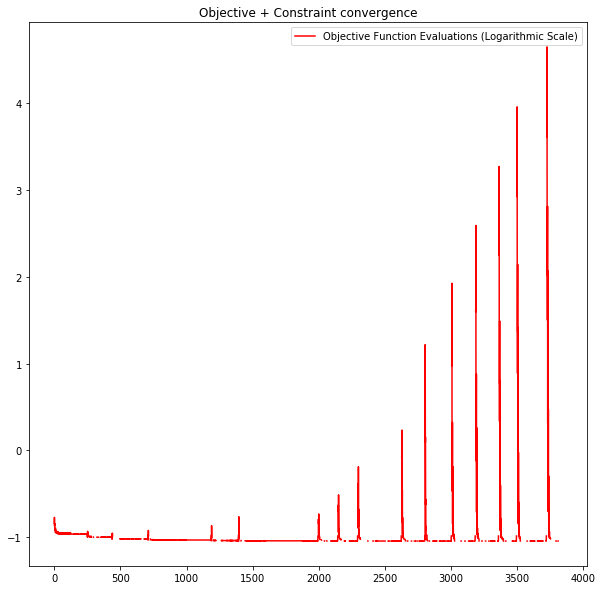

In [95]:
# Results, this is the big boi function
if __name__ == '__main__': # Testing
    test_alt = trajectory(X0[0], X0[1], dia, X0[2], x_init=launch_site_alt, dt=time_step).alt[-1]
    if (test_alt < cons_alt) or (test_alt > cons_ceiling): # rudimentary error handling to save heartache
        raise Exception('Rocket altitude out of bound! Apogee {:.3f} km'.format(test_alt/1000))
        
    # feed initial design into iterative optimizer, get best design
    res = iterate(f, X0, iterations)
    print("Optimization done!")
    
    # Rename the optimized output for convenience
    L    = res[0]
    mdot = res[1]
    p_e  = res[2]
    #dia = res[3] # in case we want diameter to be a design variable
    
    # get trajectory info from optimal design
    sim = trajectory(L, mdot, dia, p_e, x_init=launch_site_alt, dt=time_step)  
    
    # get/print info about our trajectory and rocket
    res_text = print_results(res)
    for line in res_text:
        print(line)
    print('Engine system details in trajectory log!')
    print('\nMaking an OpenRocket rocket and corresponding engine!')
    
    # create an openrocket file with matching engine for our design (and print/save trajectory data)
    make_engine(mdot, sim.m_prop[0], dia, sim.F[0:sim.F_index + 1], sim.t[sim.F_index], sim.Ve/g_n, res_text)
    
    # draw pretty pictures of optimized trajectory
    rocket_plot(sim.t, sim.alt, sim.v, sim.a, sim.F, sim.q, sim.Ma, sim.m, sim.p_a, sim.D)
    
    # draw more pretty pictures, but of the optimizer guts
    design_grapher()

Above, we can see the details of each iteration of the optimization sequence.

Then, we have the read-out of the latest and greatest rocket. Note that the relevant low-level details from *openrocket_interface* are in the text file saved.

There is a nice plot of our final trajectory and some of the state variables we may care about, which can be enlightening.

Then there are three projections of the optimization path as well as its 3D visualization. I find this extremely informative for getting a sense of how an initial design is improved.

The next cool visualization is of our design variables normalized by the eventual optimum. This is cool to see how vectors move closer to where they settle. Note that spikes occur where iterations begin, since the Nelder-Mead method flails wildly until it knows how far it can move.

Finally, there is a plot of the merit functions of our entire sequence of rockets. The spikes are again from the beginning of iterations. This is what we want to see, the punishment for deviation from feasibility is exponentially increasing with each iteration, but the minimum of each iteration is decreasing. That means our problem is well-conditioned. An ill-conditioned problem would have an increasing minimum with each iteration, since there would be no feasible design. Note this graph is semilog, because it's prettier that way. Gaps appear where a rocket ended outside of the altitude window.

## Conclusion and Next Steps
Clearly, our rocket design is viable. Experimenting with it in OpenRocket is a good idea, to make sure the stability requirement set by Base-11 is met (calibers > 2 throughout flight), as well as to experiment with different masses and fins, as well as environmental conditions such as wind or pointing 85 degrees up. Is it optimal? I'm not allowed to say. Is it the limit of a sequence? I'm not allowed to say.

Our sequence of merit evaluations is bounded below clearly (such as by 0) but is not bounded above, since some rockets shoot to infinity. However, provided that the problem is well-conditioned, the subsequence of minimums from each iteration taken as a set, is bounded above and eventually monotonically decreasing. So, it seems reasonable to infer that an ideal optimal rocket does exist, even though we don't know anything about it. This script approximates that theoretical rocket, whether it is a good approximation might be a qualitative judgement. There are other methods, and different choices that could have been made. I have endeavored to write code that is flexible enough to swap assumptions on the fly, so hopefully this is useful and continues to be so throughout at least the design process of LV4.

It is important to remember that the difference between design constants and variables is stipulative. We could easily fix *p_e* and/or make *D* a variable again. The chamber pressure has been stipulated and determines the thermodynamic properties that made us select the oxygen/fuel ratio we stipulate. It may be a good idea to have a chemistry major write a side script that generalizes *OF* as an optimized function of chamber pressure so we are not locked into these specific values.

It may also be a good idea to generalize *dry_mass* to include the possibility for subsystems being overweight similarly to the capability built into *thrust*. We could also take the maximum merit evaluation of a sample of rockets in the neighborborhood of a given design inside of each minimization. Those together could allow us to do a robust optimization (minmax problem) where we search for a rocket that isn't too sensitive to the inevitable engineering flaws that reality entails. That would obviously take a lot of computation time, but the neighborhood could be evaluated in parallel.

It may also be a good idea to try other optimization methods. There's a little block in the Python file for using SciPy's differential genetic algorithm.

## Note that everything below this point is unimportant, just me experimenting with visualizations of the data from our optimization.
I think it's pretty, but there's no important info and I may even remove it. It's just pictures of stuff around the last iteration of rockets (150ish of them).

In [96]:
d_L = [0]
d_mdot = [0]
d_p_e = [0]
interval = 150

for i in range(len(allvectors)-1):
    d_L.append(allvectors[i+1][0] - allvectors[i][0])
    d_mdot.append(allvectors[i+1][1] - allvectors[i][1])
    d_p_e.append(allvectors[i+1][2] - allvectors[i][2])

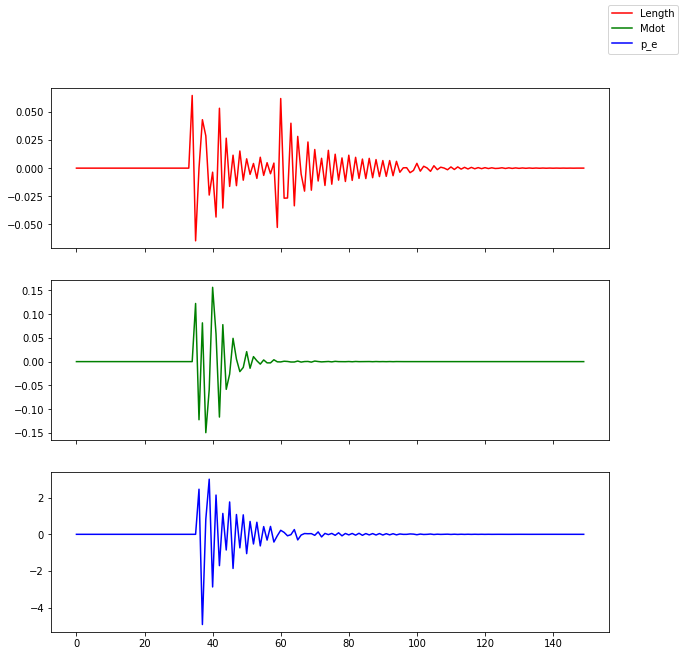

In [97]:
# plot of last few differences
start = interval
fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=True)
ax1.plot(d_L[-start:], "r", label='Length')
ax2.plot(d_mdot[-start:], "g", label='Mdot')
ax3.plot(d_p_e[-start:], "b", label='p_e')
fig.legend()
plt.show()

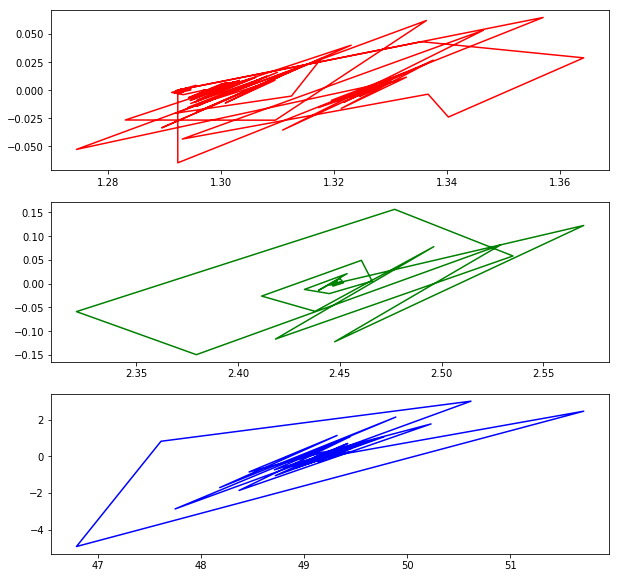

In [98]:
# phase portrait of differences and values near end of optimization
start = len(allvectors) - interval
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot([i[0] for i in allvectors][start:],d_L[start:], "r")
ax2.plot([i[1] for i in allvectors][start:],d_mdot[start:], "g")
ax3.plot([i[2] for i in allvectors][start:],d_p_e[start:], "b")
plt.show()

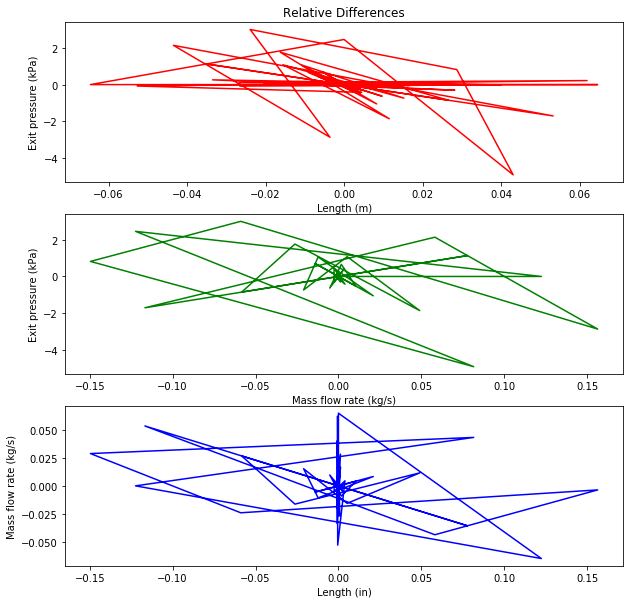

In [99]:
# phase portrait of differences and values near end of optimization
start = len(allvectors) - interval
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.set_title('Relative Differences')
ax1.plot(d_L[start:],d_p_e[start:], "r")
ax1.set_xlabel("Length (m)")
ax1.set_ylabel("Exit pressure (kPa)")
ax2.plot(d_mdot[start:],d_p_e[start:], "g")
ax2.set_xlabel("Mass flow rate (kg/s)")
ax2.set_ylabel("Exit pressure (kPa)")
ax3.plot(d_mdot[start:],d_L[start:], "b")
ax3.set_ylabel("Mass flow rate (kg/s)")
ax3.set_xlabel("Length (in)")
plt.show()

In [100]:
# average difference quotients at end
print("average difference quotients near end of optimization")
temp1 = []
offset = interval
for i in range(offset):
    if d_mdot[i-offset] != 0:
        temp1.append(d_L[i-offset]/d_mdot[i-offset])
print("dL/dmdot", np.average(temp1))
temp2 = []
for i in range(offset):
    if d_p_e[i-offset] != 0:
        temp2.append(d_L[i-offset]/d_p_e[i-offset])
print("dL/dpe", np.average(temp2))

temp1 = []
for i in range(offset):
    if d_L[i-offset] != 0:
        temp1.append(d_mdot[i-offset]/d_L[i-offset])
print("dmdot/dL", np.average(temp1))
temp2 = []
for i in range(offset):
    if d_p_e[i-offset] != 0:
        temp2.append(d_mdot[i-offset]/d_p_e[i-offset])
print("dmdot/dpe", np.average(temp2))

temp1 = []
for i in range(offset):
    if d_L[i-offset] != 0:
        temp1.append(d_p_e[i-offset]/d_L[i-offset])
print("dpe/dL", np.average(temp1))
temp2 = []
for i in range(offset):
    if d_mdot[i-offset] != 0:
        temp2.append(d_p_e[i-offset]/d_mdot[i-offset])
print("dpe/dmdot", np.average(temp2))

average difference quotients near end of optimization
dL/dmdot 40.1113327765
dL/dpe -0.127127072326
dmdot/dL 0.165411278751
dmdot/dpe -0.00337115112726
dpe/dL -122.565627003
dpe/dmdot -264.632699916
